# Práctica 4: Planificación de trayectorias

## Inteligencia Artificial para la Robótica
### M.U en Lógica, Computación e Inteligencia Artificial
### Universidad de Sevilla

En esta práctica implementaremos los algoritmos **RRT** y **RRT\*** para planificación de trayectorias en robótica. Recuerda que estos algoritmos exploran el espacio libre de obstáculos de forma aleatoria, generando un árbol de posibilidades en dónde los nodos representan estados del robot y las aristas representan transiciones entre estados de acuerdo al correspondiente modelo cinemático. 

 * El algoritmo RRT encuentra una ruta si existe, sin considerar costes. 
 * El algoritmo RRT* además minimiza un determinado coste.


Usaremos las siguientes simplificaciones:

* Robot holonómico en 2D (puede moverse en cualquier dirección, los estados vienen representados por coordenadas X,Y)
* Función de coste: Distancia del camino recorrido
* Los obstáculos serán estructuras rectangulares
* Consideraremos que los robots tienen un centro y un radio, para chequear si el robot está libre de colisiones, hay que comprobar que la distancia entre cualquier obstáculo y el centro del robot es mayor que el radio.

In [1]:
# IMPORTS
import random
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

from utils.DrawRobot import DrawRobot
from matplotlib.patches import Rectangle
from utils.tcomp import tcomp


## Ejercicio 1:
Completa la clase **Point** para representar un punto en el plano. 

Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.

In [2]:
class Point:
    def __init__(self, x, y):
        # x e y son números reales representando coordenadas en el plano
        self.x = x
        self.y = y
        
    def distance(self, p):
        # p es un objeto de la clase Point.
        
        # Completa este método,
        # debe devolver la distancia Euclidea entre self y el punto p
        dx = (self.x-p.x)**2
        dy = (self.y-p.y)**2
        return np.sqrt(dx+dy)

    def steer(self, p, length):
        # p es un objeto de la clase Point y length es un número real positivo.
        
        # Completa este método,
        # debe devolver un nuevo punto avanzando desde self hacia el punto p en línea recta una longitud length
        dirx = (p.x-self.x)
        diry = (p.y-self.y)
        modulo = (dirx/self.distance(p),diry/self.distance(p))
        return Point(self.x+modulo[0]*length,self.y+modulo[1]*length)
        
    def draw(self, ax,color='c',markersize=2):
        ax.plot(self.x,self.y,'o',color=color, markersize=markersize, linewidth=2)



1.5
4.123105625617661


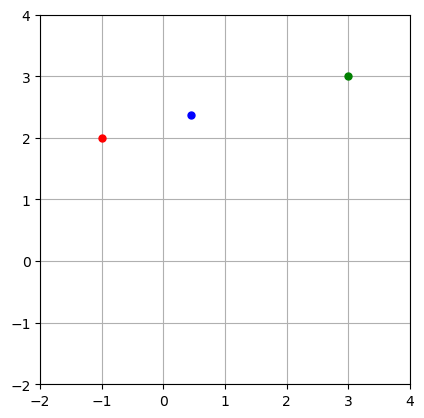

In [3]:
# Usa el siguiente código para probar tu clase Point

p0 = Point(-1,2)
goal = Point(3,3)
p1 = p0.steer(goal,1.5)
print(p0.distance(p1))
print(p0.distance(goal))
fig,ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-2,4))
plt.ylim((-2,4))
plt.grid()
p0.draw(ax,markersize=5,color='r')
p1.draw(ax,markersize=5,color='b')
goal.draw(ax,markersize=5,color='g')


plt.show()


## Ejercicio 2:

Completa la clase **Segment** para representar un segmento en el plano.

Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.


In [4]:
class Segment:
    def __init__(self,p0,p1):
        # p0 y p1 son objetos de la clase Point
        self.p0 = p0
        self.p1 = p1
        self.length = p0.distance(p1)
        
    def partition(self):
        # Completa este código,
        # debe devolver una tupla con dos segmentos, el primero desde p0 hasta (p0+p1)/2 y el segundo
        # desde (p0+p1)/2 hasta p1
        x= (self.p0.x+self.p1.x)/2
        y= (self.p0.y+self.p1.y)/2
        pInter = Point(x,y)
        S1 = Segment(self.p0,pInter)           
        S2 = Segment(pInter,self.p1)
        return (S1,S2)
        
    def draw(self,ax,color='c'):
        ax.plot([self.p0.x, self.p1.x], [self.p0.y, self.p1.y], marker='o', color=color, markersize=3, linewidth=1 )
        
    def distance(self,p):
        # Este método devuelve la distancia del punto p al segmento self
        
        if self.length < 1e-7:
            return p.distance(self.p0)
        
        x0 = self.p0.x
        y0 = self.p0.y
        x1 = self.p1.x
        y1 = self.p1.y
        x = p.x
        y = p.y
        
        t = max(0, min(1, ((x - x0) * (x1 - x0) + (y - y0) * (y1 - y0)) / (self.length**2)))
        closest_point = Point(x0 + t * (x1 - x0), y0 + t * (y1 - y0))
        return p.distance(closest_point)
    
    def distance_to_segment(self, other_segment):
        # Este método devuelve la distancia entre el segmento self y el segmento other_segment
        
        # Check if the segments intersect
        if self.intersects(other_segment):
            return 0

        # Calculate distances between endpoints
        distances = [
            self.distance(other_segment.p0),
            self.distance(other_segment.p1),
            other_segment.distance(self.p0),
            other_segment.distance(self.p1)
        ]

        return min(distances)
    
    def intersects(self, other_segment):
        # Devuelve true si el segmento self cruza el segmento other_segment
        
        # Check if the two segments intersect
        x1, y1 = self.p0.x, self.p0.y
        x2, y2 = self.p1.x, self.p1.y
        x3, y3 = other_segment.p0.x, other_segment.p0.y
        x4, y4 = other_segment.p1.x, other_segment.p1.y

        def orientation(p, q, r):
            val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
            if val == 0:
                return 0
            return 1 if val > 0 else 2

        o1 = orientation(Point(x1, y1), Point(x2, y2), Point(x3, y3))
        o2 = orientation(Point(x1, y1), Point(x2, y2), Point(x4, y4))
        o3 = orientation(Point(x3, y3), Point(x4, y4), Point(x1, y1))
        o4 = orientation(Point(x3, y3), Point(x4, y4), Point(x2, y2))

        if (o1 != o2) and (o3 != o4):
            return True

        # Special cases for collinear points
        if o1 == 0 and self.on_segment(Point(x1, y1), Point(x3, y3), Point(x2, y2)):
            return True
        if o2 == 0 and self.on_segment(Point(x1, y1), Point(x4, y4), Point(x2, y2)):
            return True
        if o3 == 0 and other_segment.on_segment(Point(x3, y3), Point(x1, y1), Point(x4, y4)):
            return True
        if o4 == 0 and other_segment.on_segment(Point(x3, y3), Point(x2, y2), Point(x4, y4)):
            return True

        return False

    def on_segment(self, p, q, r):
        return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
                q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

        

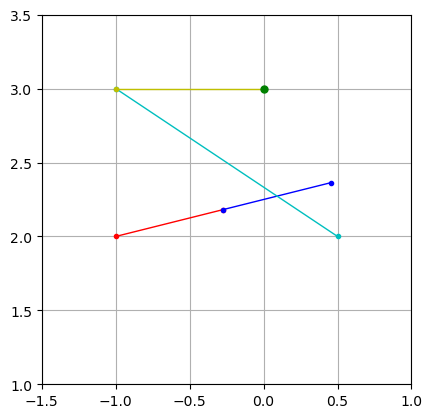

0.7935233926438485
0.81809828122275
False
True


In [5]:
# Usa el siguiente código para probar tu clase Segment

s0 = Segment(p0,p1)
s1,s2 = s0.partition()

p3 = Point(-1,3)
p4 = Point(0.5,2)
p5 = Point(0,3)

s3 = Segment(p3,p4)
s4 = Segment(p3,p5)

fig,ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1.5,1))
plt.ylim((1,3.5))
plt.grid()
s1.draw(ax,color = 'r') # segmento 1 en rojo
s2.draw(ax,color = 'b') # segmento 2 en azul
s3.draw(ax) # segmento 3 en cyan
s4.draw(ax, color = 'y') # segmento 4 en amarillo
p5.draw(ax,color = 'g', markersize = 5) # punto 5 en verde

plt.show()

print(s1.distance(p4)) # distancia del segmento 1 al punto 4
print(s1.distance_to_segment(s4)) # distancia del segmento 1 al segmento 4
print(s1.intersects(s3)) # ¿El segmento 1 cruza el segmento 3?
print(s2.intersects(s3)) # ¿El segmento 2 cruza el segmento 3?


## Ejercicio 3:

Completa la clase **Obstacle** para representar un obstáculo en el plano.

Los obstáculos tendrán forma rectangular:

```
   p3   c  p2        
    +-------+
    |       |
   d|       |b
    |       |
    +-------+
   p0   a  p1

``` 

* Los puntos p0, p1, p2 y p3 representan las 4 esquinas
* Los segmentos a,b,c,d representan los 4 lados


Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.

In [6]:
class Obstacle:
    def __init__(self, x, y, width, height):
        # Constructor que crea un obstáculo cuya esquina inferior izquierda viene dada por (x,y)
        # tiene un ancho width y una altura height
        
        self.width = width
        self.height = height
        self.p0 = Point(x,y)
        self.p1 = Point(x+width,y)
        self.p2 = Point(x+width,y+height)
        self.p3 = Point(x,y+height)
        self.a = Segment(self.p0,self.p1)
        self.b = Segment(self.p1,self.p2)
        self.c = Segment(self.p2,self.p3)
        self.d = Segment(self.p3,self.p0)
          
    def draw(self,ax):
        ax.add_patch(Rectangle((self.p0.x,self.p0.y),self.width,self.height,color = 'b'))
     
    def collision_with_robot(self,robot_center,robot_radius):
        # Devuelve True si un robot centrado en el punto robot_center 
        # y con radio robot_radius tiene colisión con el obstáculo
        
        x,y = robot_center.x,robot_center.y
        a,b,c,d = self.a,self.b,self.c,self.d
    
    
        # Determina si el centro del robot está dentro del rectángulo
        if x >= self.p0.x and x <= self.p1.x and y >= self.p0.y and y <= self.p2.y:
            return True
        
        # Determina si la distancia de cualquiera de los lados del rectángulo 
        # hasta el centro del robot es menor o igual al radio del robot
        return a.distance(robot_center) <= robot_radius or b.distance(robot_center) <= robot_radius\
    or c.distance(robot_center) <= robot_radius or\
    d.distance(robot_center) <= robot_radius 
        
  
    def collision_with_trajectory(self,trajectory,robot_radius):
        # Devuelve True si un robot con radio robot_radius realizando una trayectoria 
        # en línea recta definida por el segmento trayectory colisiona con el obstáculo
        
        a,b,c,d = self.a,self.b,self.c,self.d
        return a.distance_to_segment(trajectory) <= robot_radius or b.distance_to_segment(trajectory) <= robot_radius or c.distance_to_segment(trajectory) <= robot_radius or  d.distance_to_segment(trajectory) <= robot_radius
        
            
        

False
True
True
False
True
True


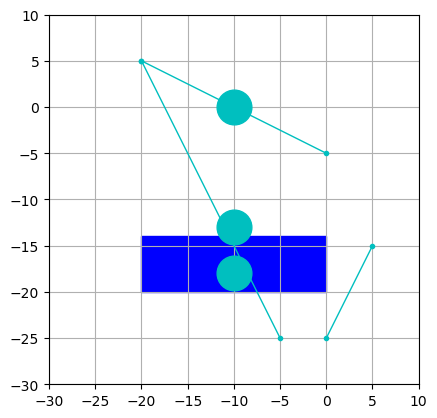

In [7]:
# Usa el siguiente código para probar tu clase Obstacle

o = Obstacle(-20,-20,20,6) # obstáculo con esquina inferior izquierda en (-20,-20), ancho 20 y altura 6
fig,ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-30,10))
plt.ylim((-30,10))
plt.grid()
o.draw(ax)


# Tenemos un robot en (-10,0) y radio 2.5 ¿colisiona con el obstáculo?
# La respuesta es False porque la distancia del centro del robot al obstáculo es mayor al radio del robot
r0 = Point(-10,0)
r0.draw(ax,markersize=25)

print(o.collision_with_robot(r0,2.5))

# Ahora el robot está en (-10,-13) ¿colisiona con el obstáculo? 
# La respuesta es True porque la distancia del centro del robot al obstáculo es inferior al radio del robot
r1 = Point(-10,-13)
r1.draw(ax,markersize=25)

print(o.collision_with_robot(r1,2.5))

# Ahora el robot está en (-10, -18) ¿colisiona con el obstáculo? 

r2 = Point(-10,-18)
r2.draw(ax,markersize=25)
# La respuesta es True porque el centro del robot está dentro del obstáculo
print(o.collision_with_robot(r2,2.5))

# El robot realiza una trayectoria desde (-20,5) hasta (0,-5) ¿colisiona con el obstáculo?
# La respuesta es False porque la distancia del segmento definido por la trayectoria con el obstáculo 
# es mayor al radio del robot
t0 = Segment(Point(-20,5),Point(0,-5))
t0.draw(ax)
print(o.collision_with_trajectory(t0,2.5))

# Ahora el robot realiza una trayectoria desde (-20,5) hasta (-5,-25) ¿colisiona con el obstáculo?
# La respuesta es True porque la trayectoria atraviesa el obstáculo
t1 = Segment(Point(-20,5),Point(-5,-25))
t1.draw(ax)
print(o.collision_with_trajectory(t1,2.5))

# Ahora el robot realiza una trayectoria desde (0,-25) hasta  (5 ,-15 ) ¿colisiona con el obstáculo?
# La respuesta es True porque la distancia del segmento definido por la trayectoria con el obstáculo
# es inferior al radio del robot
t2 = Segment(Point(0,-25),Point(5,-15))
t2.draw(ax)
print(o.collision_with_trajectory(t2,2.5))
plt.show()

## Ejercicio 4

Completa la clase **Scenario** para representar el escenario en el que navegará el robot.

El escenario vendrá dado por una lista de obstáculos y unos límites para las coordenadas x e y

En el constructor se generará también una figura de Matplotlib para la representación gráfica

Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.


In [8]:
class Scenario:
    def __init__(self,obstacles,xmin = -30, xmax = 30, ymin = -30, ymax = 30):
        self.obstacles = obstacles
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.fig, self.ax = plt.subplots()
        plt.ion()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        plt.grid()
        
        # Dibuja los obstáculos
        for obstacle in self.obstacles:
            obstacle.draw(self.ax)
    
    def collision_with_robot(self,robot_center,robot_radius):
        # Devuelve True si el robot definido por el punto robot_center y  el radio robot_radius 
        # colisiona con alguno de los obstáculos
        return any( [(obstacle.collision_with_robot(robot_center,robot_radius)) for obstacle in self.obstacles])
               
       
    def collision_with_trajectory(self,trajectory,robot_radius):
        # Devuelve True si la trayectoria definida por el segmento trajectory y el radio robot_radius
        # colisiona con alguno de los obstáculos
        return any( [(obstacle.collision_with_trajectory(trajectory,robot_radius)) for obstacle in self.obstacles])
        
            
        
        

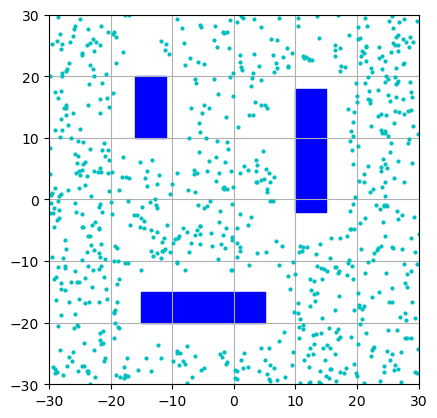

In [9]:
# Usa el siguiente código para probar tu clase Scenario

o1 = Obstacle(-15,-20,20,5)
o2 = Obstacle(10,-2,5,20)
o3 = Obstacle(-16,10,5,10)

# definimos un escenario con 3 obstáculos
scenario = Scenario([o1,o2,o3])

# El siguiente bucle genera 10000 puntos aleatorios y solamente dibuja los que no tienen colisión
# con un robot de radio 3.5
# Aviso: El bucle puede tardar unos segundos en ejecutarse

for i in range(0,1000):
    x = random.uniform(scenario.xmin, scenario.xmax)
    y = random.uniform(scenario.ymin, scenario.ymax)
    p = Point(x,y)
    if not scenario.collision_with_robot(p,3.5):
        p.draw(scenario.ax)
    
plt.show()   
    

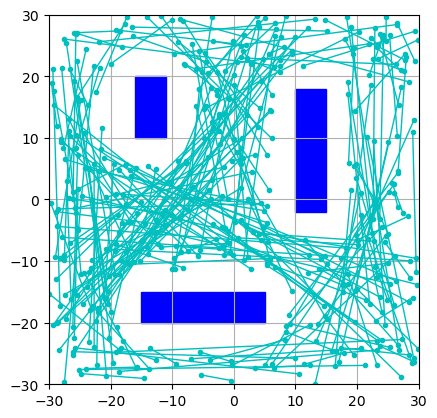

In [10]:
# Este código prueba la colisión con trayectorias
# Es análogo al anterior, pero en lugar de generar puntos aleatorios, genera segmentos

o1 = Obstacle(-15,-20,20,5)
o2 = Obstacle(10,-2,5,20)
o3 = Obstacle(-16,10,5,10)

# definimos un escenario con 3 obstáculos
scenario = Scenario([o1,o2,o3])

# Aviso: El bucle puede tardar unos segundos en ejecutarse
for i in range(0,1000):
    x0 = random.uniform(scenario.xmin, scenario.xmax)
    y0 = random.uniform(scenario.ymin, scenario.ymax)
    x1 = random.uniform(scenario.xmin, scenario.xmax)
    y1 = random.uniform(scenario.ymin, scenario.ymax)
    t = Segment(Point(x0,y0),Point(x1,y1))
    if not scenario.collision_with_trajectory(t,3.5):
        t.draw(scenario.ax)
    
plt.show()   
    

## Ejercicio 5

Vamos a definir las clases Node y Tree para poder representar las estructuras de datos necesarias
para los algoritmos RRT y RRT*

Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.

In [19]:
class Node:
    def __init__(self,point,parent=None): # No cambiar este None
        # Un nodo de un árbol vendrá dado por un punto (x,y) y una referencia al nodo padre. 
        # Si el padre es None, entonces el nodo en cuestión es la raiz del árbol
        self.point = point
        self.parent = parent
        
        # Establecemos el coste del nodo:
        # Coste = 0 si el nodo es la raiz del árbol
        # En caso contrario, 
        #   Coste = coste del nodo padre + longitud del segmento entre el nodo padre y el nodo actual
        if parent == None: # No cambiar este None
            self.cost = 0
        else:
            self.cost = 1+self.parent.cost
            
    def draw(self,ax,color='c'):
        # Dibuja el nodo como un segmento hacia el nodo padre. Si el nodo es la raiz, no lo dibuja
        if self.parent!=None: # No cambiar este None
            Segment(self.parent.point,self.point).draw(ax,color)

In [20]:
class Tree:
    def __init__(self,x0=0,y0=0):
        # (x0,y0) son las coordenadas del nodo raiz del árbol
        # self.nodes será la lista de nodos del árbol, inicialmente sólo con el nodo raiz
        self.nodes = [Node(Point(x0,y0))]
    
    def get_nearest_node(self,p):
        # Obtiene el nodo más cercano en el árbol al punto p
        return min(self.nodes,key = lambda n : n.point.distance(p))
        
    
    def get_path(self,p,error_threshold):
        # Devuelve un camino representado como una lista de nodos desde la raiz hasta el nodo más cercano
        # en el árbol al punto p. 
        # Si la distancia del nodo más cercano al punto p es mayor que error_threshold, devuelve None
        n = self.get_nearest_node(p)
        if n.point.distance(p) > error_threshold:
            return None # No cambiar este None
        path = [n]
        while n is not None:
            path.append(n)
            n = n.parent  
        path.reverse()  
        return path
               
    def draw(self,ax):
        # Dibuja los nodos del árbol
        for node in self.nodes:
            node.point.draw(ax)
            # Añado los segmentos
            if node.parent!=None:
                segment = Segment(node.point,node.parent.point)
                segment.draw(ax)

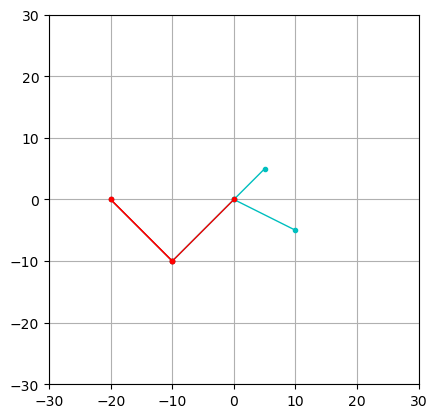

In [21]:
# Utiliza el siguiente código para probar tus clases Node y Tree

fig,ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.grid()

tree = Tree()

n1 = Node(Point(5,5),tree.nodes[0])
tree.nodes.append(n1)

n2 = Node(Point(10,-5),tree.nodes[0])
tree.nodes.append(n2)

n3 = Node(Point(-10,-10),tree.nodes[0])
tree.nodes.append(n3)

n4 = Node(Point(-20,0),n3)
tree.nodes.append(n4)

tree.draw(ax)
path1 = tree.get_path(Point(-20,0),0.1)

for n in path1:
    n.draw(ax,color='r')

plt.show()



## Ejercicio 6

Implementa la clase RRT como clase hija de Tree, incluye un metodo iterate para realizar una iteración del algoritmo RRT

Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.

In [22]:
class RRT(Tree):
     def iterate(self,scenario,edge_length,robot_radius):
        x_rand = random.uniform(scenario.xmin, scenario.xmax)
        y_rand = random.uniform(scenario.ymin, scenario.ymax)
        p_rand = Point(x_rand,y_rand)
        nearest_node = self.get_nearest_node(p_rand)
        p_new = nearest_node.point.steer(p_rand,edge_length)
        trajectory = Segment(nearest_node.point,p_new)
        if not scenario.collision_with_trajectory(trajectory,robot_radius):
            node = Node(p_new,nearest_node)
            self.nodes.append(node)
        else:
            node = None
        return node
            

In [23]:
# Usa el siguiente código para probar tu clase RRT

def main(tree, iterations):
    o1 = Obstacle(-15,-20,20,5)
    o2 = Obstacle(10,-2,5,20)
    o3 = Obstacle(-16,10,5,10)
    scenario = Scenario([o1,o2,o3])
    for i in range(0,iterations):
        tree.iterate(scenario,5,3.5)
    tree.draw(scenario.ax)  
    path = tree.get_path(Point(20,10),5)
    if path != None:
        for x in path:
            x.draw(scenario.ax,color='r')
        print("Cost: ", path[-1].cost )
    else:
        print("Path not found")


In [ ]:
# Aviso: Puede tardar unos segundos
# Prueba a ejecutar diversas veces y comprobar que salen diferentes caminos,
# en algunas ocasiones podría ocurrir que no se devuelva un camino porque no ha habido tiempo suficiente
main(RRT(),400)

## Ejercicio 7

Implementa la clase RRT_star como clase hija de Tree, incluye un metodo iterate para realizar una iteración del algoritmo RRT*

Escribe tu código en dónde pone *pass* o *None*, aunque también puedes realizar las modificaciones que estimes oportunas.

In [24]:
class RRT_star(Tree):
    def get_cost(self,node,point,scenario,robot_radius):
        # Esta función devuelve el coste del camino que alcanza el punto point desde el nodo node.
        # Si hay colision, devuelve 9999999. En caso contrario, el coste es el coste de node + la longitud
        # del segmento entre node.point y point
        trajectory = Segment(node.point,point)
        if scenario.collision_with_trajectory(trajectory,robot_radius):
            return 9999999
        return node.cost + trajectory.length
    
    def iterate(self,scenario,edge_length,robot_radius):
        x_rand = random.uniform(scenario.xmin, scenario.xmax)
        y_rand = random.uniform(scenario.ymin, scenario.ymax)
        p_rand = Point(x_rand,y_rand)
        nearest_node = self.get_nearest_node(p_rand)
        p_new = nearest_node.point.steer(p_rand,edge_length)
        trajectory = Segment(nearest_node.point,p_new)
        if scenario.collision_with_trajectory(trajectory,robot_radius):
            return 
        nmin = min(self.nodes,key = lambda n : self.get_cost(n,p_new,scenario,robot_radius))
        nnew = Node(p_new,nmin)
        self.nodes.append(nnew) 
        for n in self.nodes:
            t = Segment(n.point,nnew.point)
            if not scenario.collision_with_trajectory(t,robot_radius) and nnew.cost + t.length < n.cost:
                n.parent = nnew
                n.cost = nnew.cost + t.length

Cost:  14


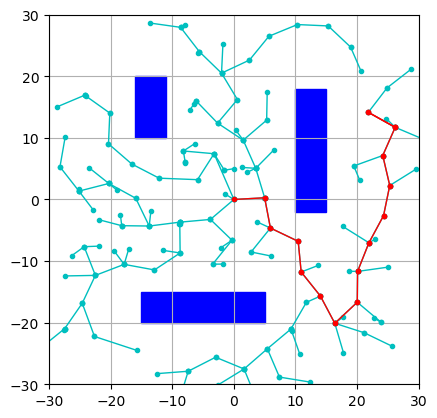

In [25]:
# Usa la siguiente llamada para comprobar tu clase RRT_star
# Aviso: puede tardar algunos segundos, puedes probar con menos iteraciones si tarda demasiado, pero los mejores
# resultados se obtendrán con más iteraciones, prueba diferentes números de iteraciones. 
main(RRT_star(),200)

## Conclusiones de la práctica
En la celda a continuación, discute lo que se ha hecho en el cuaderno, lo que has encontrado interesante o cualquier otro pensamiento relevante.

<span style="color:orangered">***Escribe tu respuesta aquí***</span>

En esta práctica hemos comenzado a utilizar la programación orientada a objetos para poder crear de una forma más simple la representación de un escenario con obstaculos y las rutas de un robot. Gracias a esta representación hemos podido estudiar y hacer una implementación de los algoritmo RRT y RRT estrella. 
La diferencia fundamental entre ambos ha resultado ser que el RRT estrella buscará siempre el camino óptimo, mejorando en cada iteración las distancias previamente calculadas.

## Ejercicio opcional

El tiempo de computación tanto del algoritmo RRT como del RRT* se podría mejorar sustancialmente.

Una posibilidad es utilizar la estructura de datos KD-tree (https://en.wikipedia.org/wiki/K-d_tree) para la representación de los árboles y para buscar el nodo más cercano.


* **Analiza, implementa y compara diferentes mejoras algorítmicas y de implementación de los algoritmos RRT y RRT* aquí incluidos.**

